In [1]:
from nanocontrol import nanocontrol, controller
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import time
import pandas as pd

### Configure

In [2]:
controller = controller()
nc = controller.ncs['1']

In [3]:
def reset():
    nc.setFinePosVoltage('A', 0)
    nc.setFinePosVoltage('B', 0)
    nc.setFinePosVoltage('C', 0)
    nc.setFinePosVoltage('D', 0)
    nc.resetCoarseCounter()
    nc.resetCounter()

In [4]:
print(nc.readCounter())
print(nc.getCoarseCounters())

{'A': '0', 'B': '0', 'C': '-1', 'D': '0'}
{'A': '0', 'B': '0', 'C': '0', 'D': '0'}


In [5]:
finerange16 = np.arange(-32768, 32768, 1).astype(int)
finerange12 = np.arange(-2048, 2047, 1).astype(int)

### Record hysteresis

In [21]:
# sweep the voltage from -80000 to 80000 in 1000 steps
reset()
hysteresis = pd.DataFrame(columns=['finestep', 'counter_asc', 'counter_desc'], dtype=int)
hysteresis['finestep'] = finerange16[::16]

# iterate over the rows of the dataframe
for index, row in tqdm(hysteresis.iterrows(), total=len(hysteresis)):
    nc.setFinePos16Bit('C', int(row['finestep']))
    hysteresis.at[index, 'counter_asc'] = int(nc.readCounter()['C'])

# iterate backwards
for index, row in tqdm(hysteresis.iloc[::-1].iterrows(), total=len(hysteresis)):
    nc.setFinePos16Bit('C', int(row['finestep']))
    hysteresis.at[index, 'counter_desc'] = int(nc.readCounter()['C'])

hysteresis.to_csv('./data/hysteresis_stepsize16_inputspeed8.csv', index=False)

100%|██████████| 4096/4096 [02:11<00:00, 31.26it/s]


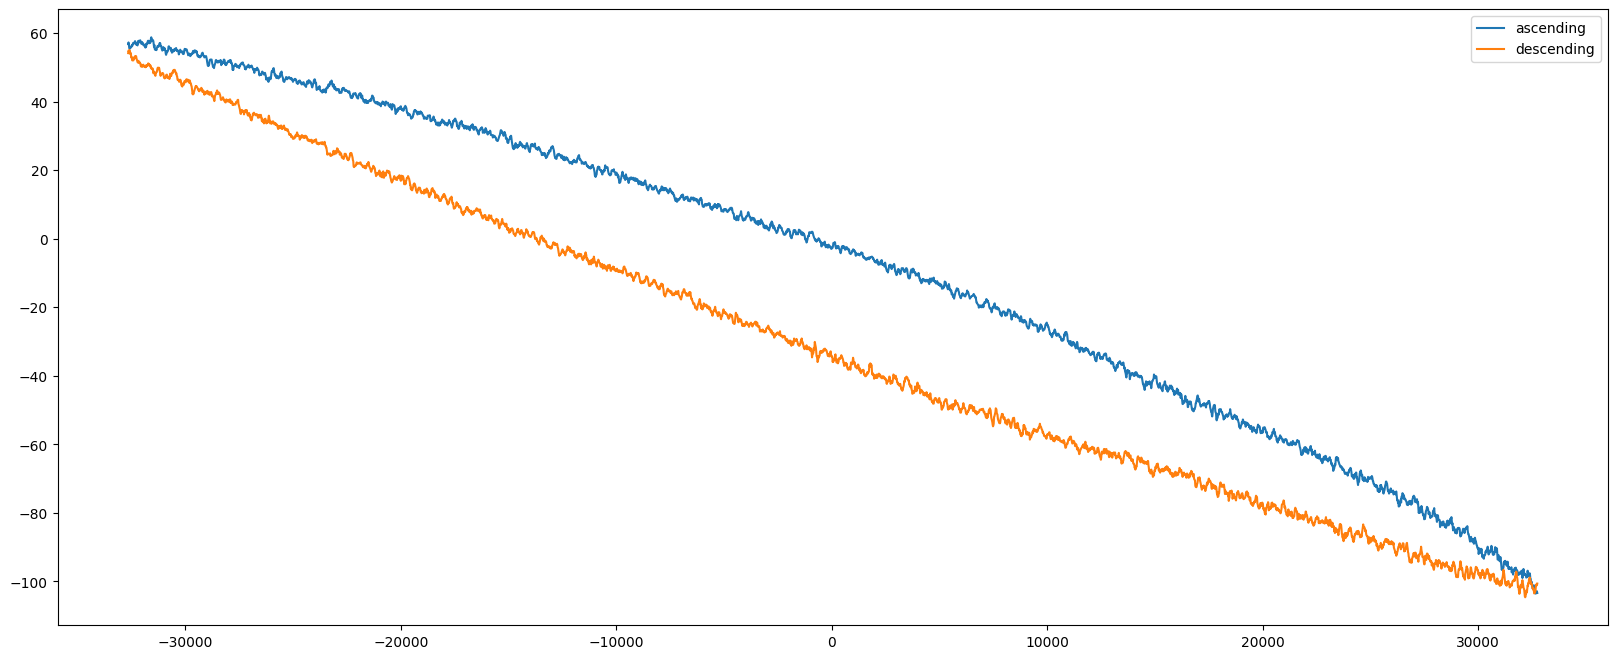

In [80]:
hysteresis = pd.read_csv('./data/hysteresis_stepsize16_inputspeed8.csv')
rolling = 8
fig, ax = plt.subplots(figsize=(20, 8))
ax.plot(hysteresis['finestep'], hysteresis['counter_asc'].rolling(window=rolling).mean(), label='ascending')
ax.plot(hysteresis['finestep'], hysteresis['counter_desc'].rolling(window=rolling).mean(), label='descending')
ax.legend()
plt.show()

### Record drift

#### KN Creep Correction

In [55]:
# reset the position and wait for 2 minutes
reset()
nc.setFinePos12Bit('C', 0)
time.sleep(120)

In [56]:
reset()
pos = []
voltage = []

nc.setFinePos12Bit('C', 1800)

start = time.time()
while time.time() - start < 60:
    pos.append(nc.readCounter()['C'])
    voltage.append(nc.getFinePosVoltage()['C'])

nc.setFinePos12Bit('C', 50)
nc.creepCorrection(a=0, b=0, c=-1750, d=0)

start = time.time()
while time.time() - start < 120:
    pos.append(nc.readCounter()['C'])
    voltage.append(nc.getFinePosVoltage()['C'])

nc.creepCorrection(a=0, b=0, c=0, d=0)

df_corrected = pd.DataFrame({'pos': np.array(pos).astype(int), 'voltage': np.asarray(voltage).astype(int)})
df_corrected.to_csv('./data/creep_correction_1800x60_50x120_inputspeed8.csv', index=False)

In [57]:
pos = []
voltage = []

nc.setFinePos12Bit('C', 600)

start = time.time()
while time.time() - start < 60:
    pos.append(nc.readCounter()['C'])
    voltage.append(nc.getFinePosVoltage()['C'])

nc.setFinePos12Bit('C', 50)

start = time.time()
while time.time() - start < 120:
    pos.append(nc.readCounter()['C'])
    voltage.append(nc.getFinePosVoltage()['C'])

df_uncorrected = pd.DataFrame({'pos': np.array(pos).astype(int), 'voltage': np.asarray(voltage).astype(int)})
df_uncorrected.to_csv('./data/creep_no_correction_1800x60_50x120_inputspeed8.csv', index=False)

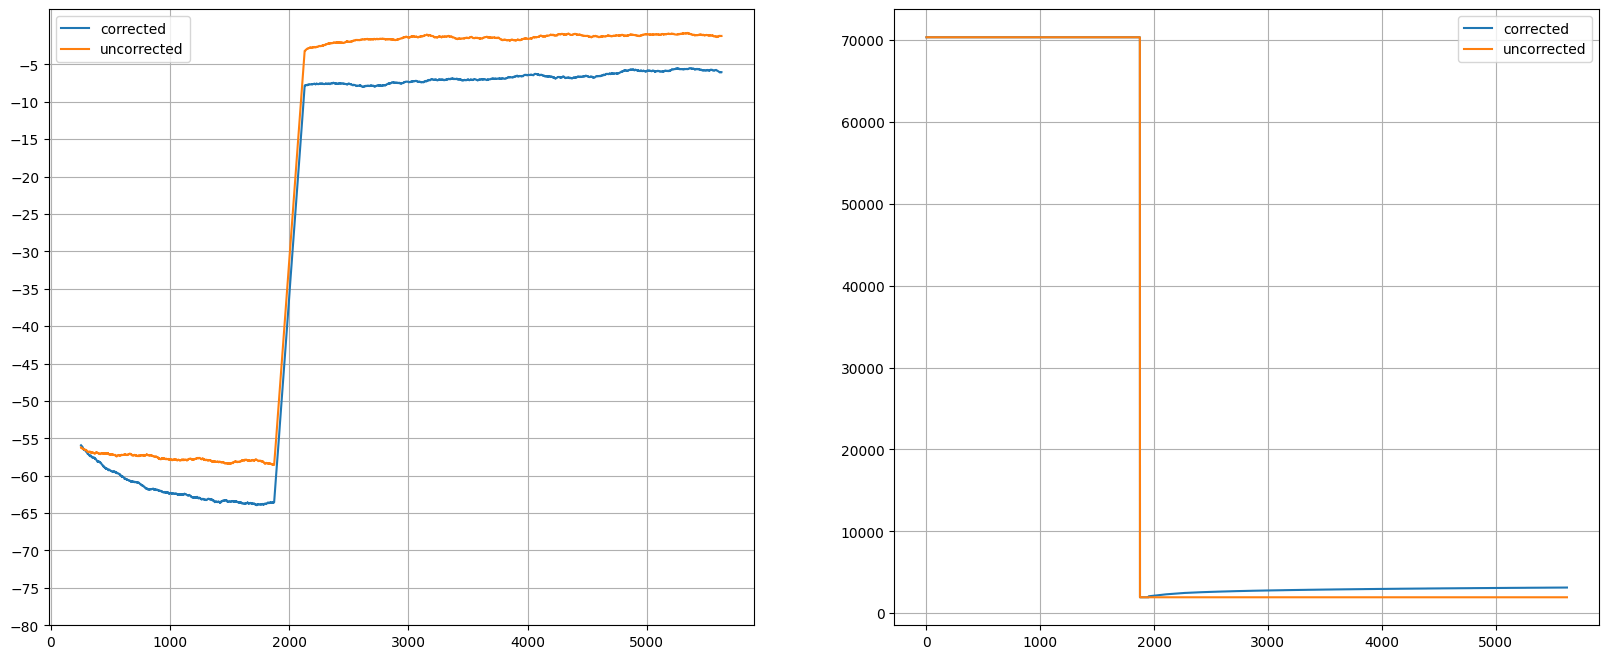

In [58]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
ax[0].plot(df_corrected['pos'].rolling(window=256).mean().astype(float), label='corrected')
ax[0].plot(df_uncorrected['pos'].rolling(window=256).mean().astype(float), label='uncorrected')
ax[0].legend()
ax[0].set_yticks(np.arange(-80, 0, 5))
ax[0].grid()
ax[1].plot(df_corrected['voltage'], label='corrected')
ax[1].plot(df_uncorrected['voltage'], label='uncorrected')
ax[1].legend()
ax[1].grid()
plt.show()

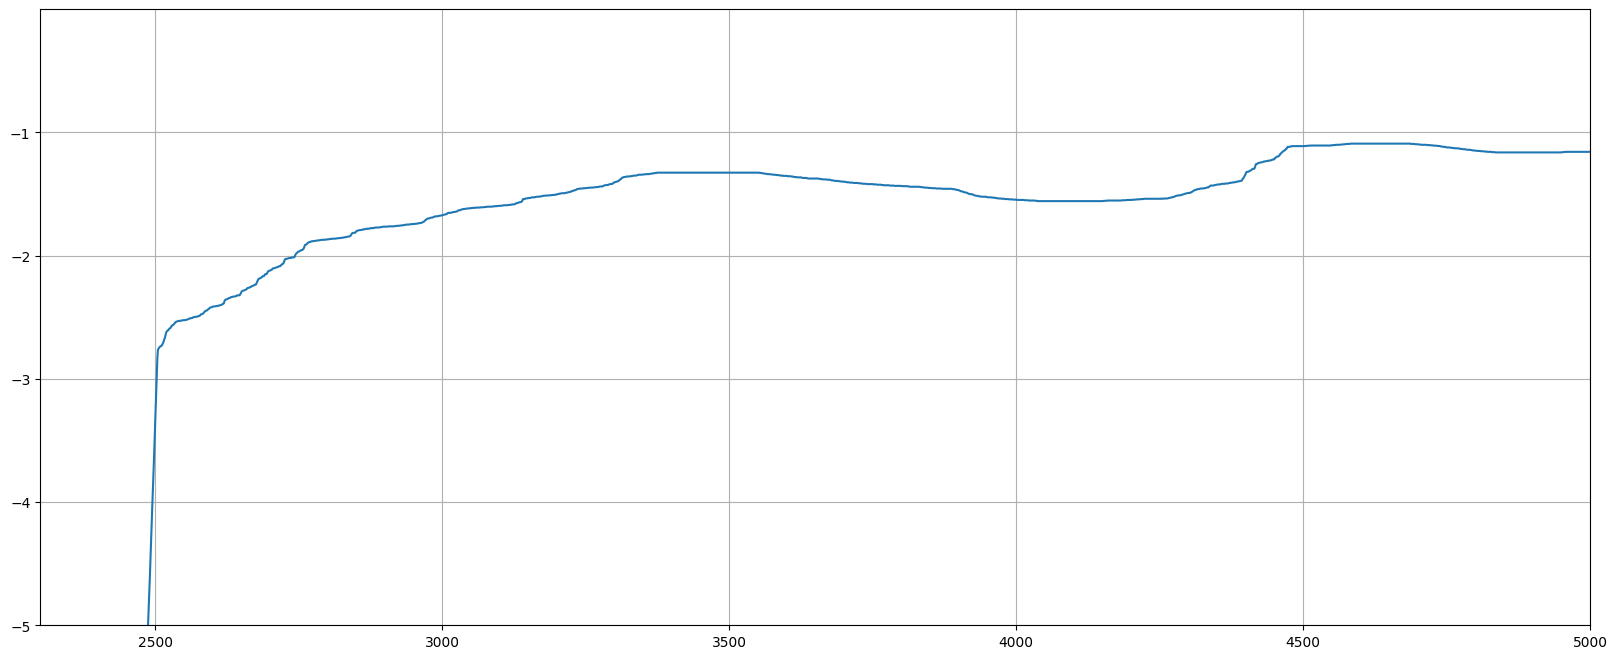

In [76]:
fig, ax = plt.subplots(figsize=(20, 8))
rolling_sec = 5 * 84
ax.plot(df_uncorrected['pos'].rolling(window=rolling_sec).mean().rolling(window=rolling_sec).median(), label='uncorrected')
ax.set_xlim(2300, 5000)
ax.set_ylim(-5, 0)
ax.set_yticks(np.arange(-5, 0, 1))
ax.grid()

#### Create input functions

In [ ]:
from matplotlib.widgets import Cursor, Button
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# Create the figure and axes
fig, ax = plt.subplots(2, 1, figsize=(10, 6))
ax.set_ylim(-32768, 32768)

# Initialize the x and y data arrays
x_data = []
y_data = []

# Create the line plot
line, = ax[0].plot(x_data, y_data)
# set limits to 0, 1
ax[0].set_xlim(0, 1)
ax[0].set_ylim(-32768, 32768)
ax[1].set_xlim(0, 1)
ax[1].set_ylim(-32768, 32768)

# Create a cursor to track the mouse position
cursor = Cursor(ax[0], useblit=True, color='red', linewidth=1)

# Function to handle mouse click events
def onclick(event):
    if event.button == 1:  # Left mouse button
        x_data.append(event.xdata)
        y_data.append(event.ydata)
        line.set_data(x_data, y_data)
        fig.canvas.draw()

# Connect the onclick event to the figure
fig.canvas.mpl_connect('button_press_event', onclick)

# Create a button to extract the function
button_ax = plt.axes([0.7, 0.05, 0.1, 0.075])
button = Button(button_ax, 'Extract')

# Function to handle button click event
def extract_function(event):
    x = np.array(x_data[:-1])
    y = np.array(y_data[:-1])
    # # expand the data to 1000 points using a mean
    # x = np.linspace(x[0], x[-1], 1000)
    # y = np.interp(x, x_data, y_data)
    
    ax[1].plot(x, y, label='Data')
    ax[1].legend()
    # clear the plot
    x_data.clear()
    y_data.clear()
    line.set_data(x_data, y_data)
    fig.canvas.draw()


# Connect the button click event to the function
button.on_clicked(extract_function)

# Show the plot
plt.show()



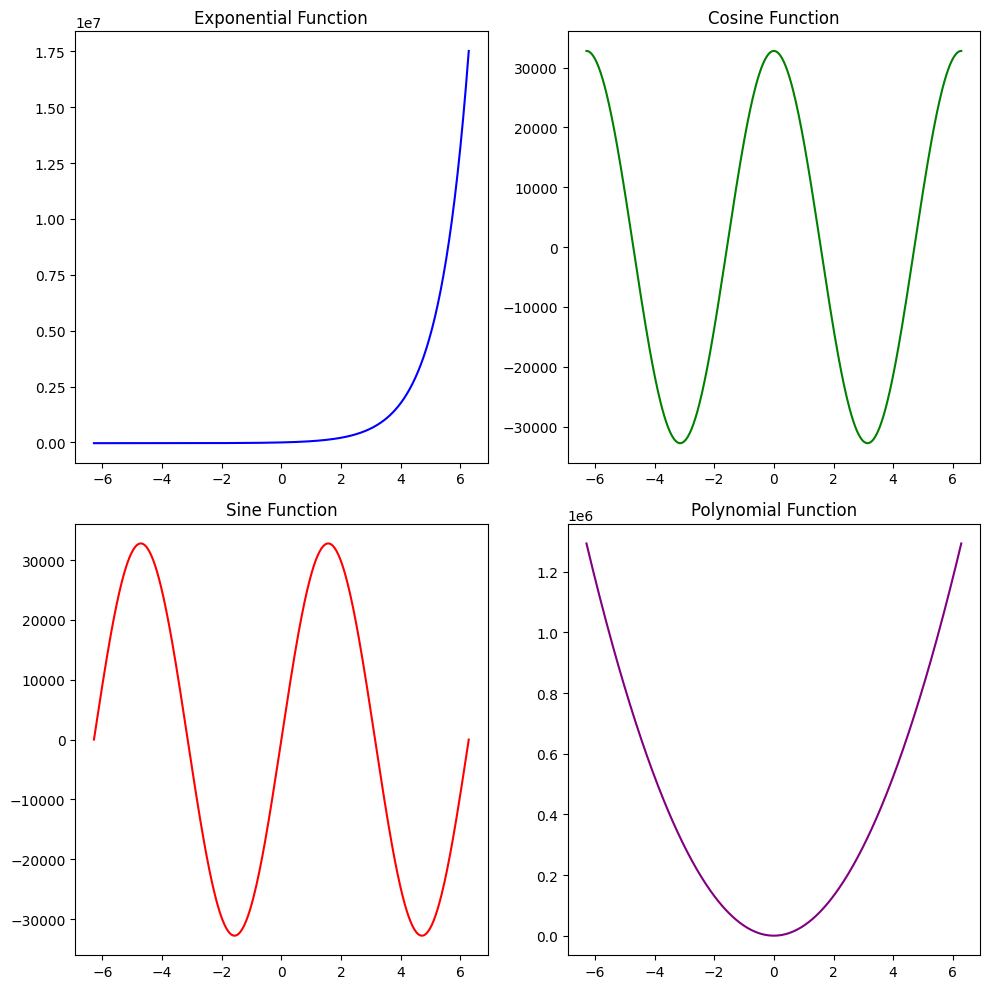

In [85]:
import numpy as np
import matplotlib.pyplot as plt

# Functions for controlling a motor
def exponential_function(x):
    return (np.exp(x) - 1) * 32768

def cosine_function(x):
    return np.cos(x) * 32768

def sine_function(x):
    return np.sin(x) * 32768

def polynomial_function(x):
    a = 1 # Coefficient of x^2
    b = 0 # Coefficient of x
    c = 0 # Constant term
    return (a*x**2 + b*x + c) * 32768

# Creating x axis with range
x = np.linspace(-2*np.pi, 2*np.pi, 400)

# Creating subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Plotting exponential function
axs[0, 0].plot(x, exponential_function(x), color='blue')
axs[0, 0].set_title('Exponential Function')

# Plotting cosine function
axs[0, 1].plot(x, cosine_function(x), color='green')
axs[0, 1].set_title('Cosine Function')

# Plotting sine function
axs[1, 0].plot(x, sine_function(x), color='red')
axs[1, 0].set_title('Sine Function')

# Plotting polynomial function
axs[1, 1].plot(x, polynomial_function(x), color='purple')
axs[1, 1].set_title('Polynomial Function')

# Adjusting layout
plt.tight_layout()

# Showing the plot
plt.show()


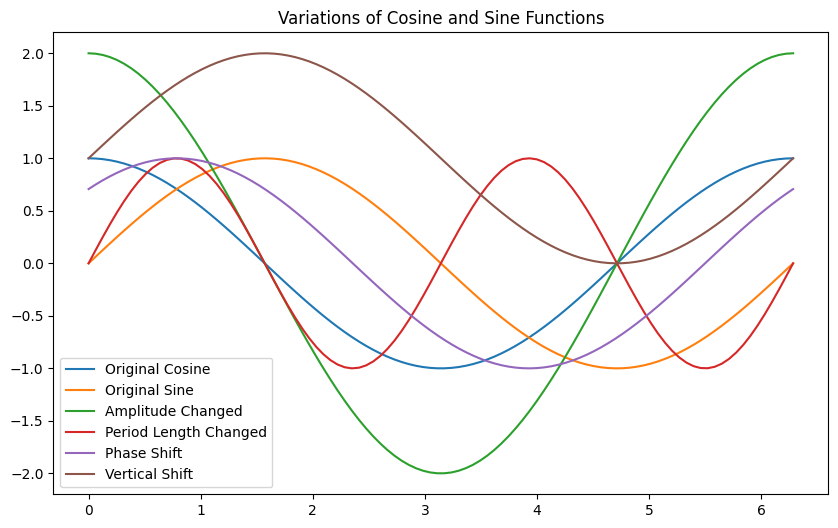

In [86]:
import numpy as np
import matplotlib.pyplot as plt

# Function to plot cosine and sine variations
def plot_variations(x):
    # Original cosine and sine functions
    y_cos = np.cos(x)
    y_sin = np.sin(x)
    
    # Variations
    y_cos_amp = 2 * np.cos(x) # Amplitude changed
    y_sin_per = np.sin(2*x) # Period length changed
    y_cos_shift = np.cos(x - np.pi/4) # Phase shift
    y_sin_vert = np.sin(x) + 1 # Vertical shift
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(x, y_cos, label='Original Cosine')
    plt.plot(x, y_sin, label='Original Sine')
    plt.plot(x, y_cos_amp, label='Amplitude Changed')
    plt.plot(x, y_sin_per, label='Period Length Changed')
    plt.plot(x, y_cos_shift, label='Phase Shift')
    plt.plot(x, y_sin_vert, label='Vertical Shift')
    plt.legend()
    plt.title('Variations of Cosine and Sine Functions')
    plt.show()

# Generate x values
x = np.linspace(0, 2*np.pi, 100)

# Plot the variations
plot_variations(x)


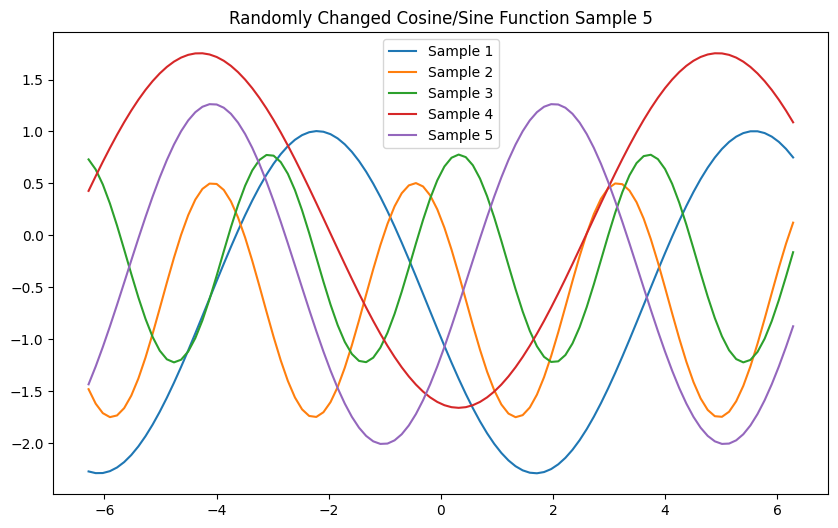

In [88]:
import numpy as np
import matplotlib.pyplot as plt

def generate_random_cos_sin_samples(n, x_range=(-2*np.pi, 2*np.pi), num_points=100):
    """
    Generate n samples of randomly changed cosine and sine functions.
    
    Parameters:
    - n: Number of samples to generate.
    - x_range: Tuple specifying the range of x values.
    - num_points: Number of points to sample for each function.
    
    Returns:
    - A list of tuples, where each tuple contains the x values and the y values (samples) of a randomly changed cosine or sine function.
    """
    samples = []
    x = np.linspace(x_range[0], x_range[1], num_points)
    
    for _ in range(n):
        # Randomly choose between cosine and sine
        func_type = np.random.choice(['cos', 'sin'])
        
        # Randomly adjust parameters
        amplitude = np.random.uniform(0.5, 2) # Random amplitude
        frequency = np.random.uniform(0.5, 2) # Random frequency
        phase_shift = np.random.uniform(0, 2*np.pi) # Random phase shift
        vertical_shift = np.random.uniform(-1, 1) # Random vertical shift
        
        if func_type == 'cos':
            y = amplitude * np.cos(frequency * x + phase_shift) + vertical_shift
        else: # func_type == 'sin'
            y = amplitude * np.sin(frequency * x + phase_shift) + vertical_shift
        
        samples.append((x, y))
    
    return samples

# Example usage
n = 5 # Number of samples
samples = generate_random_cos_sin_samples(n)

# Plotting the samples
plt.figure(figsize=(10, 6))
for i, (x, y) in enumerate(samples, start=1):
    plt.plot(x, y, label=f'Sample {i}')
plt.legend()
plt.title(f'Randomly Changed Cosine/Sine Function Sample {i}')
plt.show()


C:\Users\david\AppData\Local\Temp\ipykernel_18036\1960739185.py:24: RuntimeWarning: divide by zero encountered in divide
  y = 32768/x + vertical_shift


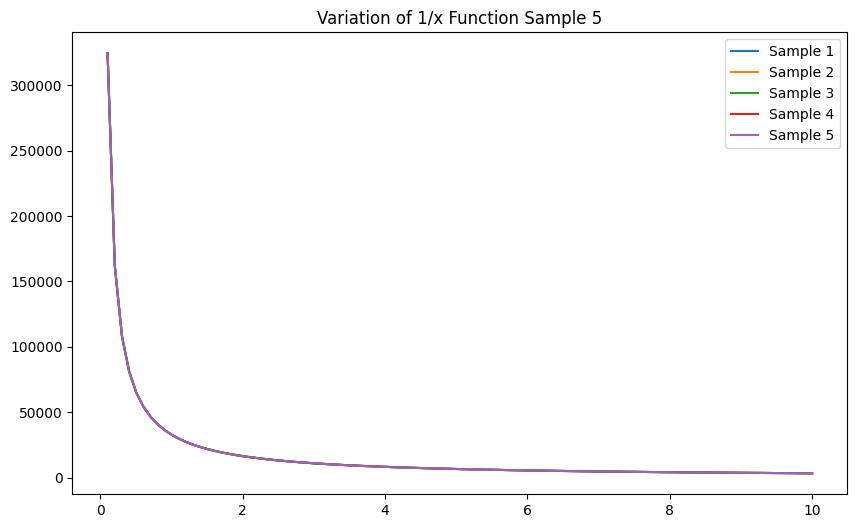

In [99]:
import numpy as np
import matplotlib.pyplot as plt

def generate_variations(n, x_range=(0, 10), num_points=100):
    """
    Generate n samples of variations of the function 1/x.
    
    Parameters:
    - n: Number of samples to generate.
    - x_range: Tuple specifying the range of x values.
    - num_points: Number of points to sample for each function.
    
    Returns:
    - A list of tuples, where each tuple contains the x values and the y values (samples) of a variation of the function 1/x.
    """
    samples = []
    x = np.linspace(x_range[0], x_range[1], num_points)
    
    for _ in range(n):
        # Randomly adjust the vertical shift
        vertical_shift = np.random.uniform(0, 10) # Random vertical shift
        
        # Apply the variation
        y = 32768/x + vertical_shift
        samples.append((x, y))
    
    return samples

# Example usage
n = 5 # Number of samples
samples = generate_variations(n)

# Plotting the samples
plt.figure(figsize=(10, 6))
for i, (x, y) in enumerate(samples, start=1):
    plt.plot(x, y, label=f'Sample {i}')
plt.legend()
plt.title(f'Variation of 1/x Function Sample {i}')
plt.show()


#### measure drift

In [61]:
stepsize = 1024
drift_minutes = 30

nc.moveCoarse('C', 1)
reset()

drift_sweep = pd.DataFrame(columns=['finestep', 'counter'], dtype=float)
drift_sweep['finestep'] = finerange[::1024]

counter_drift = []
for index, row in tqdm(drift_sweep.iterrows(), total=len(drift_sweep)):
    nc.setFinePos16Bit('C', int(row['finestep']))
    drift_sweep.at[index, 'counter'] = nc.readCounter()['C']
# read counter for the next 4 minutes, abot 83 samples per second
start = time.time()
while time.time() - start < drift_minutes * 60:
    counter_drift.append(nc.readCounter()['C'])

  0%|          | 0/64 [00:00<?, ?it/s]C:\Users\david\AppData\Local\Temp\ipykernel_18036\2251797810.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-13' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  drift_sweep.at[index, 'counter'] = nc.readCounter()['C']
100%|██████████| 64/64 [00:02<00:00, 31.08it/s]


In [75]:
drift_sweep['counter_rolling'] = drift_sweep['counter'].rolling(window=4, center=True).mean()

df_drift = pd.DataFrame({'counter': counter_drift})
df_drift['counter_rolling'] = df_drift['counter'].rolling(window=60*83, center=True).mean()

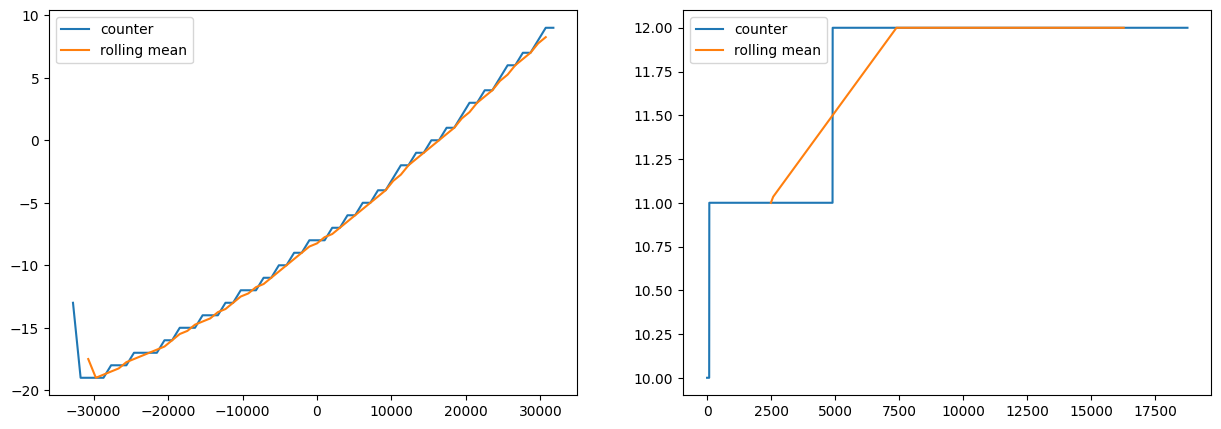

In [76]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(drift_sweep['finestep'], drift_sweep['counter'].astype(float), label='counter')
ax[0].plot(drift_sweep['finestep'], drift_sweep['counter_rolling'].astype(float), label='rolling mean')
ax[0].legend()

ax[1].plot(df_drift.index, df_drift['counter'].astype(float), label='counter')
ax[1].plot(df_drift.index, df_drift['counter_rolling'].astype(float), label='rolling mean')
ax[1].legend()
plt.show()

In [74]:
df_drift

,counter,counter_rolling
0,10,NaN
1,10,NaN
2,10,NaN
3,10,NaN
4,10,NaN
...,...,...
18753,12,12.0
18754,12,12.0
18755,12,12.0
18756,12,12.0
